## Créer un récapitulatif des statistiques extraites à partir de vigilo 

In [54]:
# Import necessary packages
import datetime  # For handling date and time
import locale  # For setting locale (language and cultural conventions)
import textwrap  # For wrapping and formatting text
import requests  # For making HTTP requests
import pandas as pd  # For data manipulation and analysis
import warnings # For disabling future warnings
import matplotlib.pyplot as plt  # For creating plots and visualizations
import seaborn as sns  # For improving the aesthetics of matplotlib plots
import overpy  # For interacting with the Overpass API for OpenStreetMap data
import geopy.distance  # For calculating distances between two points on the Earth's surface

# Setting French locale
locale.setlocale(locale.LC_ALL, 'fr_FR.UTF-8')

# Plot features
thisyear = 2023 # year data to plot
sns.set_style("darkgrid")  # Setting the background style for seaborn plots
sns.set_context("talk", font_scale=0.8)  # Setting the context and font scale for seaborn plots
blue, orange = sns.color_palette("muted", 2)  # Defining custom colors for the plot


In [81]:
# Get vigilo data for brest

# Suppressing the FutureWarning related to is_categorical_dtype
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Making an HTTP GET request to retrieve data from the Vigilo Brest database
    resp = requests.get('https://vigilo.bapav.org/get_issues.php')  # API endpoint for Vigilo Brest database
    
    # Creating a DataFrame from the JSON response
    df = pd.DataFrame(resp.json())
    
    # Removing rows with empty comments
    df = df[df.comment != '']
    
    # Converting the 'time' column to datetime format with seconds as the unit
    df.time = pd.to_datetime(df.time, unit='s')
    
    # Adding a new column 'julian_day' representing the Julian day of the year for each entry
    df['julian_day'] = df.time.apply(lambda x: x.timetuple().tm_yday)
    
    # Filtering out data before January 1, 2022
    df = df[df.time.apply(lambda x: x.year) > 2021]
    
    # Sorting the DataFrame by the 'time' column in ascending order
    df = df.sort_values(by='time', ascending=True)
    
    # Resetting the index of the DataFrame after sorting
    df = df.reset_index(drop=True)

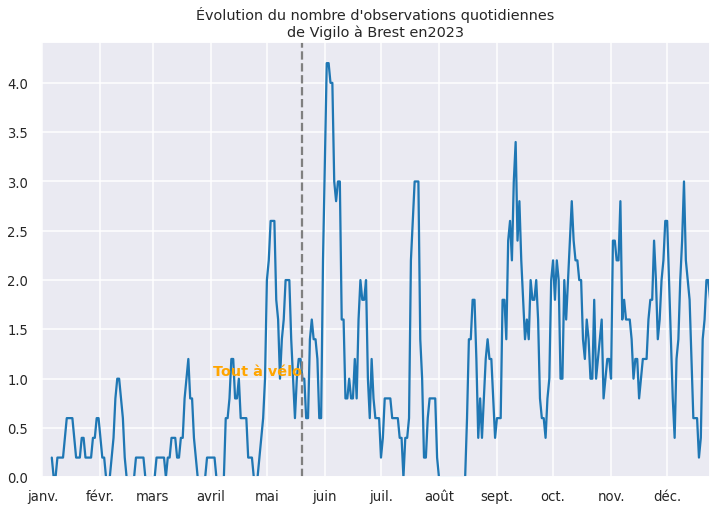

In [57]:
# Display daily number of vigilo observations

# Creating a subplot with an enlarged plot (adjust the figsize as needed)
fig, ax = plt.subplots(figsize=(12, 8))  # You can adjust the width and height as needed

# Smoothing window size in days
WINDOWS_SIZE = 5

# Counting the number of observations per Julian day
count = df.groupby('julian_day').token.count()

# Creating a Series with zero counts for missing Julian days and smoothing the count
count = pd.Series([count[x] if x in count.index else 0 for x in range(df.julian_day.min(), df.julian_day.max() + 1)],
                  range(df.julian_day.min(), df.julian_day.max() + 1))
count_smoothed = count.rolling(WINDOWS_SIZE).sum().apply(lambda x: x / WINDOWS_SIZE)

# Plotting the smoothed count
ax.plot(count_smoothed)

# Setting ticks and labels for the x-axis
ticks = [datetime.datetime(year=thisyear, month=x, day=1).timetuple().tm_yday for x in range(1, 13)]
ticks_labels = [datetime.datetime(year=thisyear, month=x, day=1).strftime('%b') for x in range(1, 13)]
plt.xticks(ticks, ticks_labels)

# Setting x-axis limits
ax.set_xlim(0, count_smoothed.dropna().index.max())

# Setting y-axis limits
ylim = ax.get_ylim()
ax.set_ylim(0, ylim[1])

# Adding a vertical dashed line and text for a specific date
challenge_date = datetime.datetime(year=thisyear, month=5, day=20).timetuple().tm_yday
ax.plot((challenge_date, challenge_date), (0, 10), '--', color='grey')
ax.text(x=challenge_date,
        y=1,
        s='Tout à vélo',
        horizontalalignment='right',
        verticalalignment='bottom',
        color='orange',
        fontweight='bold')

# Setting y-axis limits again to ensure visibility of the dashed line and text
ax.set_ylim(0, ylim[1])

# Adding title to the plot
plt.title("Évolution du nombre d'observations quotidiennes\nde Vigilo à Brest en " + str(thisyear))

# Displaying the plot
plt.show()


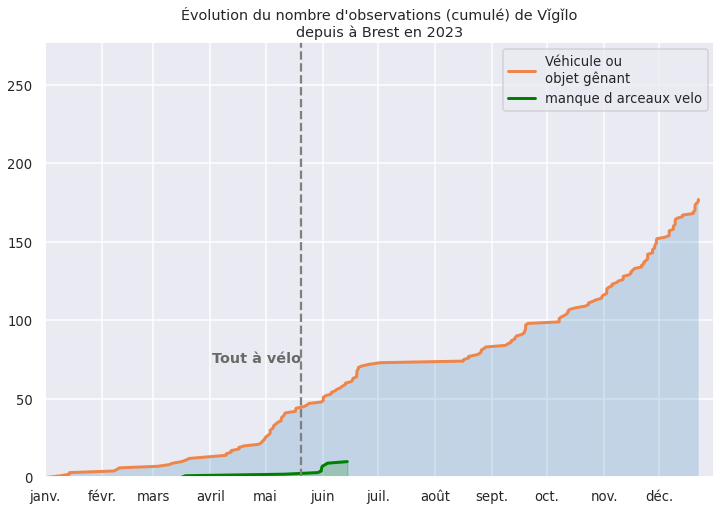

In [68]:
# Display the cumulative number of vigilo observations for one category

# Creating a subplot for the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Extracting data for 'Véhicule ou objet gênant' (id 2)
df2 = df[df.categorie == '2']
df2 = df2[df2.time.apply(lambda x: x.year) > 2022]  # Filtering data for the specified year
df2 = df2.reset_index(drop=True)
x2 = df2.time.values
y2 = df2.index.values
ax.plot(x2, y2, color=orange, lw=3, label='Véhicule ou\nobjet gênant')  # Plotting the data for 'Véhicule ou objet gênant'
ax.fill_between(x2, 0, y2, alpha=.2)

# Extracting data for 'manque d'arceaux velo' (id 5)
df5 = df[df.categorie == '5']
df5 = df5[df5.time.apply(lambda x: x.year) > 2022]  # Filtering data for the specified year
df5 = df5.reset_index(drop=True)
x5 = df5.time.values
y5 = df5.index.values
ax.plot(x5, y5, color='green', lw=3, label='manque d arceaux velo')  # Plotting the data for category 5
ax.fill_between(x5, 0, y5, alpha=.2, color='green')

# Setting x-axis ticks and labels
ticks = [datetime.datetime(year=thisyear, month=x, day=1) for x in range(1, 13)]
ticks_labels = [x.strftime('%h') for x in ticks]
plt.xticks(ticks, ticks_labels)

# Displaying the legend
plt.gca().legend()

# Setting y-axis limits
ylim = ax.get_ylim()

# Adding a vertical dashed line and text for a specific date (Vigilo release date)
challenge = datetime.datetime(year=thisyear, month=5, day=20)
ax.plot((challenge, challenge), (0, 1000000), '--', color='grey')
ax.text(x=challenge,
        y=80,
        s='Tout à vélo',
        horizontalalignment='right',
        verticalalignment='top',
        color='dimgrey',
        fontweight='bold')

# Setting x-axis and y-axis limits
ax.set_xlim(datetime.date(year=thisyear, month=1, day=1), datetime.date(year=thisyear, month=12, day=31))
ax.set_ylim(0, max(max(y2), max(y5)) + 100)  # Adjust the ylim as needed

# Adding a title to the plot
plt.title("Évolution du nombre d'observations (cumulé) de Vǐgǐlo\ndepuis à Brest en " + str(thisyear))

# Displaying the plot
plt.show()

In [70]:
# Rank schools wrt to number of badly parked vehicules (GCUM)
BUFFER_SIZE = 300  

# Getting GCUM data from the API
resp = requests.get('https://vigilo.bapav.org/get_issues.php?c=2')
gcum = resp.json()

# Getting schools using Overpass API
api = overpy.Overpass()
bbox = '48.377, -4.546, 48.416, -4.431' # GPS box around Brest
# Query to fetch schools (nodes and ways) within a bounding box
query = """(
  node["school:FR"="maternelle"]({bbox});
  way["school:FR"="maternelle"]({bbox});
  node["school:FR"="élémentaire"]({bbox});
  way["school:FR"="élémentaire"]({bbox});
  node["school:FR"="primaire"]({bbox});
  way["school:FR"="primaire"]({bbox});
  );
  out center;""".format(bbox=bbox)

result = api.query(query)

# Set "none" as the value in schools without 'name' tags
for x in result.ways:
    x.tags.setdefault('name', 'Pas de nom renseigné, coos gps: (' + str(x.center_lat) + ',' + str(x.center_lon) + ')')   

# Extracting school information (name, latitude, longitude) from Overpass API results
schools = [{'name': x.tags['name'], 'lat': x.lat, 'lon': x.lon} for x in result.nodes] + \
          [{'name': x.tags['name'], 'lat': x.center_lat, 'lon': x.center_lon} for x in result.ways]

# Filtering GCUM data based on day and time (school time)
week_gcum = [x for x in gcum
             if datetime.datetime.fromtimestamp(int(x['time'])).weekday() < 4
             and (datetime.time(hour=7, minute=30) < datetime.datetime.fromtimestamp(int(x['time'])).time() < datetime.time(hour=9)
                  or datetime.time(hour=16) < datetime.datetime.fromtimestamp(int(x['time'])).time() < datetime.time(hour=17, minute=30))]

# Counting GCUM within X meters of each school
for school in schools:
    school['gcum'] = [x for x in week_gcum if geopy.distance.great_circle((x['coordinates_lat'], x['coordinates_lon']),
                                                                     (school['lat'],
                                                                      school['lon'])).meters < BUFFER_SIZE]
    school['nb_gcum'] = len(school['gcum'])

# Sorting schools based on the number of GCUM in descending order
schools.sort(key=lambda x: len(x['gcum']), reverse=True)

# Displaying the ranking of schools by the number of GCUM nearby (within BUFFER_SIZE meters)
print("Classement des écoles de Brest par nombre de GCUM à proximité (moins de {} m) \n".format(BUFFER_SIZE))
print('\n'.join(['{} - {}'.format(x['nb_gcum'], x['name']) for x in schools if x['nb_gcum'] != 0]))


Classement des écoles de Brest par nombre de GCUM à proximité (moins de 300 m) 

8 - École primaire publique La Pointe
7 - École Javouhey
6 - Skol Diwan Brest (Kerango)
4 - École primaire privée Immaculée Conception
3 - École primaire privée de la Providence
3 - L'échappée belle
3 - École maternelle publique République-Sanquer
2 - École élémentaire publique Vauban
2 - École maternelle publique Vauban
2 - École maternelle publique Jacques Kerhoas
1 - École primaire du Petit Paris
1 - École primaire du Petit Paris
1 - Pas de nom renseigné, coos gps: (48.3863738,-4.4859900)
1 - Pas de nom renseigné, coos gps: (48.3902032,-4.5099708)
1 - Pas de nom renseigné, coos gps: (48.3863855,-4.4867933)
1 - Groupe Scolaire Kerisbian
1 - École primaire publique Jean Macé
1 - École Notre-Dame des Carmes
1 - École primaire publique Quéliverzan
1 - École maternelle publique Alice Abarnou
1 - École primaire publique Le Forestou
1 - École Sainte-Marie
1 - École élémentaire publique Jacques Kerhoas
1 - Écol

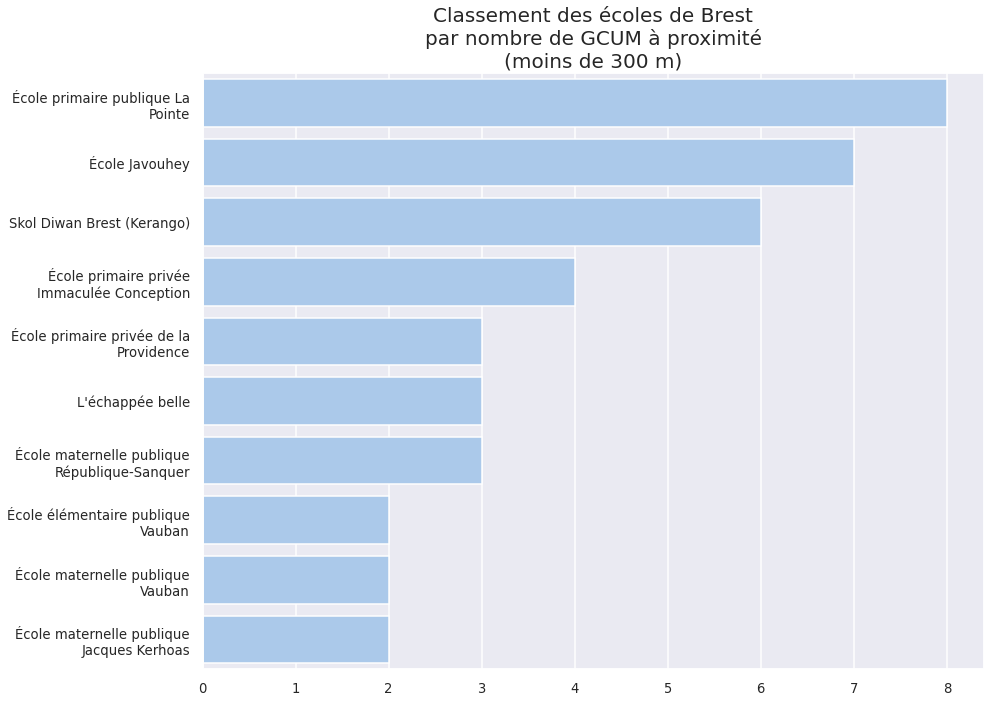

In [73]:
# Suppressing the FutureWarning related to is_categorical_dtype
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    plt.figure(figsize=(14, 10))  # You can adjust the width and height as needed

    # Setting color codes for Seaborn plot
    sns.set_color_codes("pastel")

    # Creating a bar plot using Seaborn
    # x: Number of GCUM for the top 10 schools
    # y: School names (wrapped to fit within 30 characters)
    # color: Blue color for the bars
    sns.barplot(x=[x['nb_gcum'] for x in schools[:10]],
                y=['\n'.join(textwrap.wrap(x['name'], 30)) for x in schools[:10]],
                color="b")

    # Adding title to the plot with increased font size
    plt.title("Classement des écoles de Brest\npar nombre de GCUM à proximité\n(moins de {} m)".format(BUFFER_SIZE),
              fontsize=20)  # You can adjust the fontsize as needed

    # Adjusting layout for better appearance
    plt.tight_layout()

    # Displaying the plot
    plt.show()


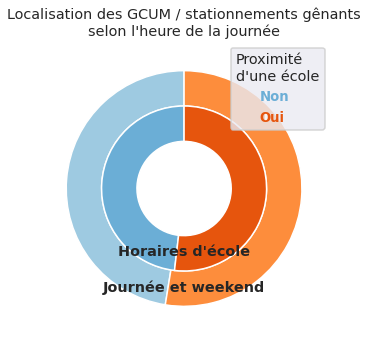

In [80]:
# Suppressing the FutureWarning related to to_datetime
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Creating a DataFrame from GCUM data
    df = pd.DataFrame(gcum)
    
    # Converting 'time' column to datetime format with seconds as the unit
    df['time'] = pd.to_datetime(df['time'], unit='s')

    # Adding a new column 'hour' with default value 'Journée et weekend'
    df['hour'] = 'Journée et weekend'
    
    # Updating 'hour' column based on the condition
    df.loc[df.token.apply(lambda x: x in [y['token'] for y in week_gcum]), 'hour'] = "Horaires d'école"

    # Adding a new column 'school' with default value 'Non'
    df["school"] = 'Non'

    # Updating 'school' column based on the proximity to schools
    for school in schools:
        df.loc[df.apply(lambda row: geopy.distance.great_circle((row['coordinates_lat'], row['coordinates_lon']),
                                                                (school['lat'],
                                                                 school['lon'])).meters < BUFFER_SIZE,
                        axis=1), "school"] = 'Oui'

    # Creating a new subplot for the pie chart
    fig, ax = plt.subplots(figsize=(5, 5))

    # Pie chart parameters
    size = 0.3
    cmap = plt.get_cmap("tab20c")
    outer_colors = cmap([2, 5])
    inner_colors = cmap([1, 4])

    # Plotting the outer pie chart
    ax.pie(x=(df.loc[df.hour == 'Journée et weekend'].loc[df.school == 'Non'].token.count(),
              df.loc[df.hour == 'Journée et weekend'].loc[df.school == 'Oui'].token.count()),
           radius=1,
           wedgeprops=dict(width=size, edgecolor='w'),
           startangle=90,
           colors=outer_colors)

    # Plotting the inner pie chart
    ax.pie(x=(df.loc[df.hour == "Horaires d'école"].loc[df.school == 'Non'].token.count(),
              df.loc[df.hour == "Horaires d'école"].loc[df.school == 'Oui'].token.count()),
           radius=1 - size,
           wedgeprops=dict(width=size, edgecolor='w'),
           startangle=90,
           colors=inner_colors)

    # Adding title to the plot
    plt.title("Localisation des GCUM / stationnements gênants\nselon l'heure de la journée")

    # Adding annotations for different time categories
    ax.annotate("Horaires d'école",
                xy=(0.5, 0.31),
                xycoords='axes fraction',
                fontweight='bold',
                verticalalignment='top',
                horizontalalignment='center')

    ax.annotate("Journée et weekend",
                xy=(0.5, 0.19),
                xycoords='axes fraction',
                fontweight='bold',
                verticalalignment='top',
                horizontalalignment='center')

    # Creating a legend for proximity to schools
    legend = ax.legend(title="Proximité\nd'une école", labels=("Non", "Oui"), handlelength=0, handletextpad=-0.5)

    # Styling the legend text
    for n, text in enumerate(legend.texts):
        text.set_color(inner_colors[n])
        text.set_fontweight('bold')

    # Adjusting layout for better appearance
    plt.tight_layout()

    # Displaying the plot
    plt.show()


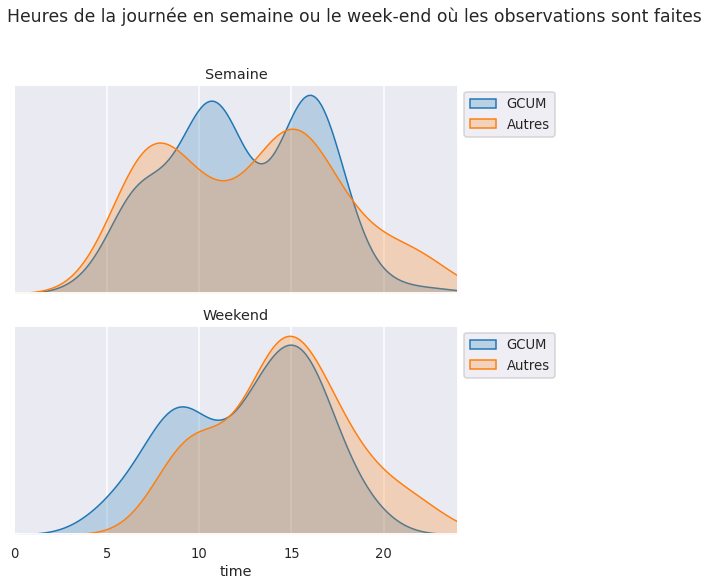

In [85]:
# Afficher les heures des observations
# Separating week days and weekends
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Converting 'time' column to datetime format with seconds as the unit
    df.time = pd.to_datetime(df.time, unit='s')
    
    # Adding a new column 'day_type' with default value 'week'
    df['day_type'] = 'week'
    
    # Updating 'day_type' column based on the condition (weekday > 4 indicates weekend)
    df.loc[df.time.apply(lambda x: x.weekday() > 4), 'day_type'] = 'weekend'
    
    # Creating subplots with shared x-axis
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 8))  # Adjusting the figure size
    
    # Plotting Kernel Density Estimate (KDE) for weekdays - GCUM
    sns.kdeplot(df[(df.categorie == '2') & (df.day_type == 'week')].time.apply(lambda x: x.hour),
                fill=True, legend='GCUM', label='GCUM', ax=ax1)
    
    # Plotting KDE for weekdays - Other categories
    sns.kdeplot(df[(df.categorie != '2') & (df.day_type == 'week')].time.apply(lambda x: x.hour),
                fill=True, label='Autres', ax=ax1)
    
    # Plotting KDE for weekends - GCUM
    sns.kdeplot(df[(df.categorie == '2') & (df.day_type == 'weekend')].time.apply(lambda x: x.hour),
                fill=True, legend='GCUM', label='GCUM', ax=ax2)
    
    # Plotting KDE for weekends - Other categories
    sns.kdeplot(df[(df.categorie != '2') & (df.day_type == 'weekend')].time.apply(lambda x: x.hour),
                fill=True, label='Autres', ax=ax2)
    
    # Setting titles for the subplots
    ax1.set_title('Semaine')
    ax2.set_title('Weekend')
    
    # Setting x-axis limits
    ax1.set_xbound(0, 24)
    
    # Hiding y-axis labels for better clarity
    ax1.get_yaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    # Adding a title above the plot
    plt.suptitle("Heures de la journée en semaine ou le week-end où les observations sont faites", y=1.02)
    
    # Adding a legend on the right
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # Adjusting layout for better appearance
    plt.tight_layout(rect=[0, 0, 0.8, 1])
    
    # Displaying the plot
    plt.show()


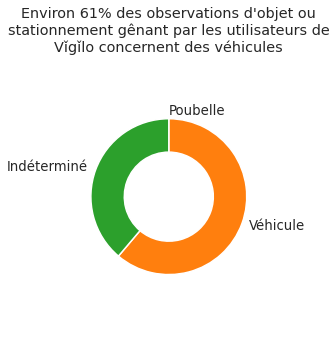

In [87]:
# Types de observations stationnement genants

# Getting the total number of observations
total = len(df)

# Filtering observations related to 'poubelles' (trash bins or containers)
poubelles = df[df.comment.str.lower().str.match(r'.*(poubelle|conteneur).*')]
df = df[~df.token.isin(poubelles.token)]  # Removing poubelles from the original DataFrame

# Filtering observations related to 'vehicules' (vehicles, parking, etc.)
vehicules = df[df.comment.str.lower().str.match(r'.*(voiture|station|garé|gare|gcum|parking|'
                                                r'moto|scooter|véhicule|utilitaire|camion|pv).*')]
autres = df[~df.token.isin(vehicules.token)]  # Remaining observations categorized as 'autres' (others)

# Creating a pie chart to visualize the distribution of observations
fig, ax = plt.subplots(figsize=(5, 5))
size = 0.3
min_proportion = 0.04
cmap = plt.get_cmap("tab20c")

# Plotting the pie chart with proportions of different observation types
ax.pie(x=[len(poubelles), len(vehicules), len(autres)],
       radius=1 - size,
       wedgeprops=dict(width=size, edgecolor='w'),
       startangle=90,
       labels=['Poubelle', 'Véhicule', 'Indéterminé'],
       labeldistance=1.1,
       counterclock=False,
       pctdistance=0.8)

# Creating a title for the pie chart based on the proportion of vehicle-related observations
title = '\n'.join(textwrap.wrap("Environ {0:.0%} des observations d'objet ou stationnement "
                                "gênant par les utilisateurs de Vǐgǐlo concernent des véhicules".format(
    len(vehicules) / total), 50))
plt.title(title)

# Adjusting layout for better appearance
plt.tight_layout()

# Displaying the pie chart
plt.show()
